In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from matplotlib import pyplot as plt, gridspec

from torchvision import datasets, transforms as T


train_augs = T.Compose([
    T.RandomRotation((-20,20)),
    T.ToTensor() 
])

train_set  = datasets.MNIST(root='D:/data/MNIST', download=True, transform=train_augs)

mnist_dataloader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4) 

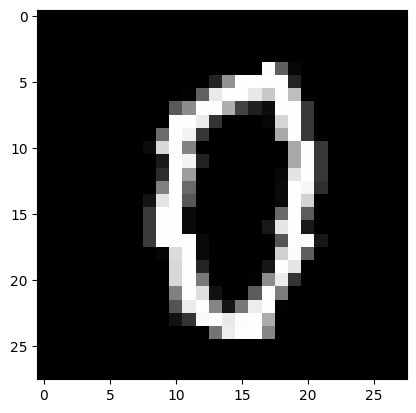

In [11]:
image , label =train_set[1000]
plt.imshow(image.squeeze(), cmap = 'gray')

# Гиперпараметры

In [12]:
device = 'cpu'   

batch_size = 128 

noise_dim = 64  


lr = 0.0002
beta_1  = 0.5
beta_2  = 0.99

epochs = 20

#  Dataset в Batches

In [13]:
from torch.utils.data import  DataLoader
from torchvision.utils import make_grid

#len_sliced = 12000
#tr_sliced = torch.utils.data.random_split(train_set, [len_sliced, len(train_set)-len_sliced])[0]


trainloader = DataLoader(train_set, batch_size=batch_size, shuffle= True)
print('Total number of batches in train loader', len(trainloader))

Total number of batches in train loader 469


# Discriminator


In [14]:
from torch import nn
from torchsummary import summary

In [15]:
from torch.nn.modules.activation import LeakyReLU
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [16]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    self.block_1 = get_disc_block(1, 16, (3,3), 2)
    self.block_2 = get_disc_block(16, 32, (5,5), 2)
    self.block_3 = get_disc_block(32, 64, (5,5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features=64, out_features=1)

  def forward(self,images):
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)

    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5

In [17]:
D = Discriminator()
D.to(device)

summary(D, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Generator

In [18]:
from torch.nn.modules import ReLU
from torch.nn.modules.batchnorm import BatchNorm2d
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [19]:
class Generator(nn.Module):
  def __init__(self,noise_dim):
    super(Generator, self).__init__()
    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)

    self.block_2 = get_gen_block(256, 128, (4,4), 1)

    self.block_3 = get_gen_block(128, 64, (3,3), 2)

    self.block_4= get_gen_block(64, 1, (4,4), 2, final_block=True)

  def forward(self, r_noise_vec):
     x = r_noise_vec.view(-1, self.noise_dim, 1, 1)
     X1 = self.block_1(x)
     X2 = self.block_2(X1)
     X3 = self.block_3(X2)
     X4 = self.block_4(X3)
     return X4

In [20]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size=(1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

# Random Weights

In [21]:

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)


In [22]:
D =D.apply(weights_init)
G = G.apply(weights_init)

In [23]:


def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [24]:
# потеря когда ождиаемый результат 1
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

# потеря когда ождиаемый результат 0
def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [25]:
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta_1, beta_2))

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch ; 1 | D_loss : 0.6850703639516444 | G_loss 0.6902100081636962


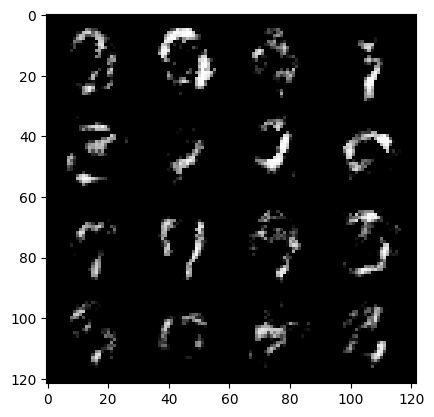

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch ; 2 | D_loss : 0.6712824143072181 | G_loss 0.7176720632164717


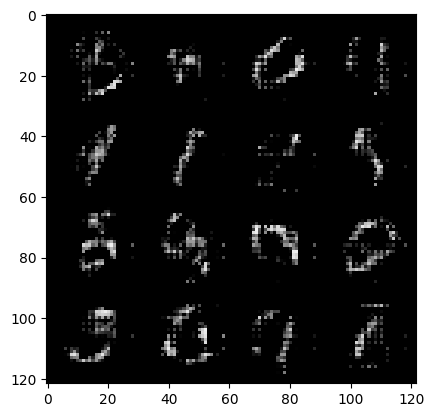

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch ; 3 | D_loss : 0.6409038009165701 | G_loss 0.7523348490312409


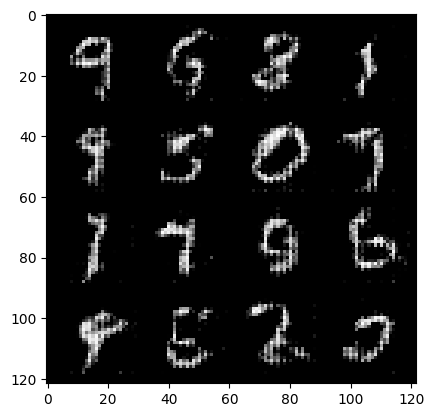

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch ; 4 | D_loss : 0.6273671886814174 | G_loss 0.7763955435519025


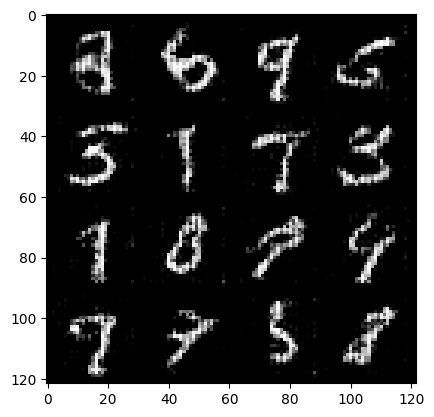

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch ; 5 | D_loss : 0.61931323051961 | G_loss 0.7998801091078248


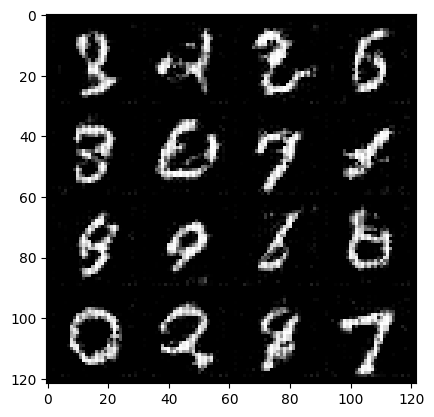

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch ; 6 | D_loss : 0.6220567875833654 | G_loss 0.8093446709199755


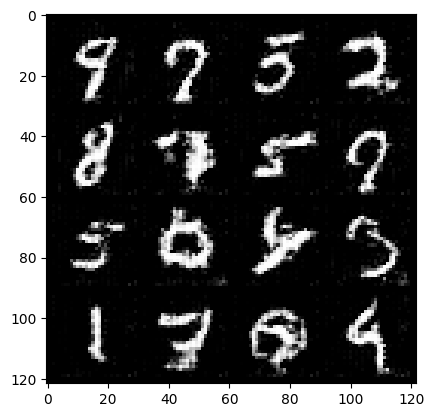

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch ; 7 | D_loss : 0.6356472719961138 | G_loss 0.8011295166351139


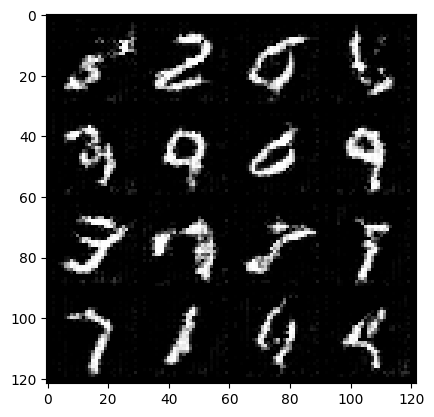

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch ; 8 | D_loss : 0.6492748991258617 | G_loss 0.7898694378480728


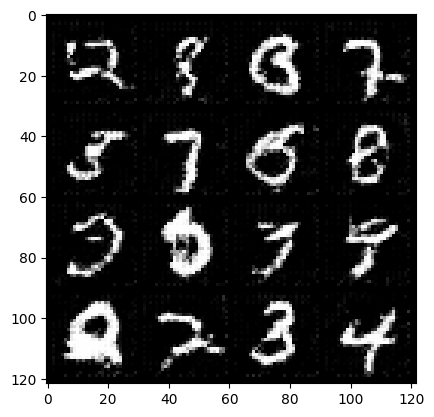

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch ; 9 | D_loss : 0.6566531011290642 | G_loss 0.7841507281575885


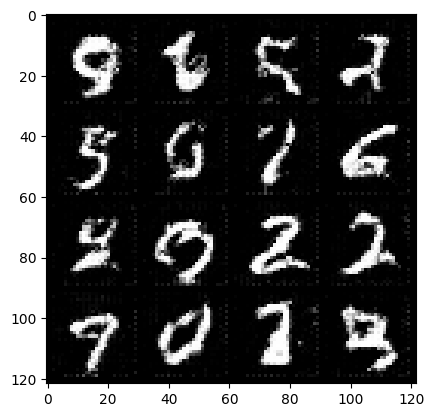

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch ; 10 | D_loss : 0.6595413857685731 | G_loss 0.7805023246736669


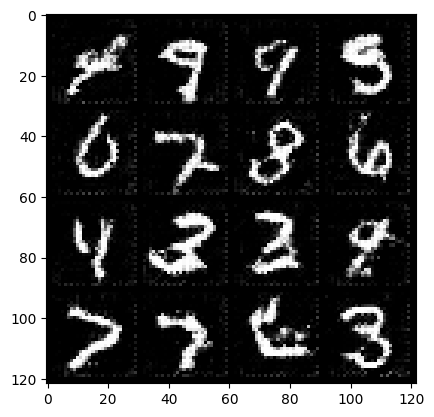

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
from tqdm.notebook import tqdm

for i in range(epochs):

  total_d_loss = 0.0
  total_g_loss = 0.0

  for  real_img, _ in tqdm(trainloader):
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device=device)


    D_opt.zero_grad()
    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2

    total_d_loss += D_loss.item()
    D_loss.backward()
    D_opt.step()

    G_opt.zero_grad()
    oise = torch.randn(batch_size, noise_dim, device=device)
    fake_img = G(noise)
    D_pred = D(fake_img)

    G_loss = real_loss(D_pred)


    total_g_loss += G_loss.item()
    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss/len(trainloader)
  avg_g_loss = total_g_loss/len(trainloader)

  print("Epoch ; {} | D_loss : {} | G_loss {}".format(i+1, avg_d_loss, avg_g_loss))
  show_tensor_images(fake_img)